<a href="https://colab.research.google.com/github/Mostafa3zazi/CISC-856-Reinforcement-Learning/blob/main/Assignment2_RL_Windy_Grid_World.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2 Reinforcement Learning CISC 856, Winter, 2022

<pre>(Sutton & Barto, pg. 130,131)
Consider the game depicted in the following diagram:
You are to implement several algorithms to solve this problem:
1. Sarsa
2. Q-learning
Compare all solutions in terms of the optimal policies and episodes necessary for convergence. Select
the best values for 𝜀 and 𝛼 for each case. If they are different, discuss why.
</pre>

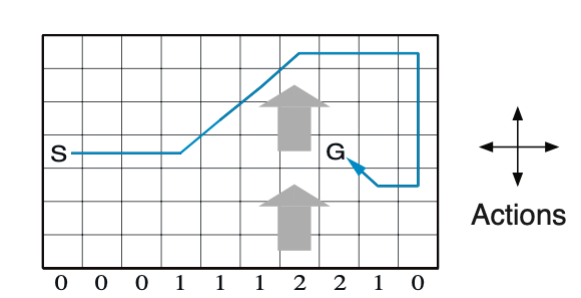

<pre>Re-solve the windy gridworld task with King’s moves, assuming that the effect of the wind, if there is
any, is stochastic, sometimes varying by 1 from the mean values given for each column. That is, a third
of the time you move exactly according to these values, as in the previous exercise, but also a third of
the time you move one cell above that, and another third of the time you move one cell below that.
For example, if the agent is one cell to the right of the goal and it chooses to move left, then one-third of
the time the agent will move one cell above the goal, one-third of the time you move two cells above
the goal, and one-third of the time you move to the goal. YOU SHOULD ONLY USE THIS APPROACH.
Mathematically, when the wind is defined by 𝑤, the location of the agent in 𝑦 after the execution of the
action without stochastic wind will be 𝑦 = 𝑎(𝑠) + 𝑤. Then, the stochastic output 𝑦! will be:</pre>

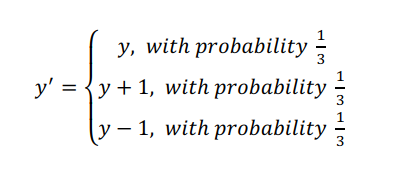

#  Installation of required tools -
We will use Open AI's gym environment for this tutorial. Use the code from previous tutorial to render Gym in Google colab! Or install gym using following code in your local notebook:

```
! pip install git+https://github.com/openai/gym.git
```



This code is from previous openAiGym.ipynb notebook

In [ ]:
!pip install -q gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -q -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install -q colabgymrender==1.0.2
import gym
from colabgymrender.recorder import Recorder

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3522560/45929032 bytes (7.7%)7020544/45929032 bytes (15.3%)10608640/45929032 bytes (23.1%)14090240/45929032 bytes (30.7%)17833984/45929032 bytes (38.8%)21536768/45929032 bytes (46.9%)25141248/45929032 bytes (54.7%)28499968/45929032 bytes (62.1%)32104448/45929032 bytes (69.9%)35725312/45929032 bytes (77.8%)39370752/45929032 bytes (85.7%)42868736/45929032 bytes (93.3%)

In [ ]:
# To check all environments available
from gym import envs 
print(envs.registry.all())

dict_values([EnvSpec(Copy-v0), EnvSpec(RepeatCopy-v0), EnvSpec(ReversedAddition-v0), EnvSpec(ReversedAddition3-v0), EnvSpec(DuplicatedInput-v0), EnvSpec(Reverse-v0), EnvSpec(CartPole-v0), EnvSpec(CartPole-v1), EnvSpec(MountainCar-v0), EnvSpec(MountainCarContinuous-v0), EnvSpec(Pendulum-v0), EnvSpec(Acrobot-v1), EnvSpec(LunarLander-v2), EnvSpec(LunarLanderContinuous-v2), EnvSpec(BipedalWalker-v3), EnvSpec(BipedalWalkerHardcore-v3), EnvSpec(CarRacing-v0), EnvSpec(Blackjack-v0), EnvSpec(KellyCoinflip-v0), EnvSpec(KellyCoinflipGeneralized-v0), EnvSpec(FrozenLake-v0), EnvSpec(FrozenLake8x8-v0), EnvSpec(CliffWalking-v0), EnvSpec(NChain-v0), EnvSpec(Roulette-v0), EnvSpec(Taxi-v3), EnvSpec(GuessingGame-v0), EnvSpec(HotterColder-v0), EnvSpec(Reacher-v2), EnvSpec(Pusher-v2), EnvSpec(Thrower-v2), EnvSpec(Striker-v2), EnvSpec(InvertedPendulum-v2), EnvSpec(InvertedDoublePendulum-v2), EnvSpec(HalfCheetah-v2), EnvSpec(HalfCheetah-v3), EnvSpec(Hopper-v2), EnvSpec(Hopper-v3), EnvSpec(Swimmer-v2), EnvSp

#Define the environment
this code is Copied from https://github.com/vojtamolda/reinforcement-learning-an-introduction/blob/main/chapter06/windy.py


In [ ]:
import gym
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


class WindyGridworldEnv(gym.Env):
    """ Windy Gridworld environment per Example 6.5 (defaults), Exercise 6.9 (king=True, stop=True) or
     Exercise 6.10 (king=True, stochastic=True) """
    size = (10, 7)
    start = (0, 3)
    goal = (7, 3)
    wind = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]

    stop_action = [(0, 0)]
    pawns_actions = [(0, +1), (+1, 0), (0, -1), (-1, 0)]
    kings_action = [(+1, +1), (+1, -1), (-1, -1), (-1, +1)]

    observation_space = gym.spaces.MultiDiscrete(size)
    reward_range = (-1, -1)

    def __init__(self, king=False, stop=False, stochastic=False):
        self.stochastic = stochastic
        self.king = king
        self.stop = stop

        self.actions = self.pawns_actions[:]
        if self.king:
            self.actions += self.kings_action
        if self.stop:
            self.actions += self.stop_action
        self.action_space = gym.spaces.Discrete(len(self.actions))

        self.position = None
        self.arrow = None

        self.ax = None

    def step(self, action):
        assert self.action_space.contains(action)

        # Calculate move vector and new position
        delta = self.actions[action]
        position = self.position + np.array(delta)

        # Add wind to the position
        wind = self.wind[self.position[0]]
        if self.stochastic and wind > 0:
            wind += np.random.choice([-1, 0, +1])
        position[1] += wind

        # Store position for the next step and calculate arrow for rendering
        position = np.clip(position, 0, self.observation_space.nvec - 1)
        self.arrow = position - self.position
        self.position = position

        # Check for terminal state
        done = (position == self.goal).all()
        reward = -1

        assert self.observation_space.contains(position)
        return position, reward, done, {}
    
    def c_r_to_index(self, position):
      return position[0] + (self.size[1] - 1 - position[1]) * self.size[0]


    def index_to_c_r(self, index):
      return (index % 10 , (6 - index//10))

    def reset(self):
        self.position = np.array(self.start)
        self.arrow = np.array((0, 0))
        self.ax = None
        return self.position

    def render(self, mode='human'):
        if self.ax is None:
            fig = plt.figure()
            self.ax = fig.gca()

            # Background colored by wind strength
            wind = np.vstack([self.wind] * self.size[1])
            self.ax.imshow(wind, aspect='equal', origin='lower', cmap='Blues')

            # Annotations at start and goal positions
            self.ax.annotate("G", self.goal, size=25, color='gray', ha='center', va='center')
            self.ax.annotate("S", self.start, size=25, color='gray', ha='center', va='center')

            # Major tick marks showing wind strength
            self.ax.set_xticks(np.arange(len(self.wind)))
            self.ax.set_xticklabels(self.wind)
            self.ax.set_yticks([])
            self.ax.set_yticklabels([])

            # Thin grid lines at minor tick mark locations
            self.ax.set_xticks(np.arange(-0.5, self.size[0]), minor=True)
            self.ax.set_yticks(np.arange(-0.5, self.size[1]), minor=True)
            self.ax.grid(which='minor', color='black', linewidth=0.20)
            self.ax.tick_params(which='both', length=0)
            self.ax.set_frame_on(True)

        # Arrow pointing from the previous to the current position
        if (self.arrow == 0).all():
            patch = mpatches.Circle(self.position, radius=0.05, color='black', zorder=1)
        else:
            patch = mpatches.FancyArrow(*(self.position - self.arrow), *self.arrow, color='black',
                                        zorder=2, fill=True, width=0.05, head_width=0.25,
                                        length_includes_head=True)
        self.ax.add_patch(patch)


env_dict = gym.envs.registration.registry.env_specs.copy()
for env in env_dict:
    if 'WindyGridworld-v0' in env:
        print("Remove {} from registry".format(env))
        del gym.envs.registration.registry.env_specs[env]

gym.envs.registration.register(
    id='WindyGridworld-v0',
    entry_point=lambda king, stop, stochastic: WindyGridworldEnv(king, stop, stochastic),
    kwargs={'king': False, 'stop': False, 'stochastic': False},
    max_episode_steps=5_000,
)


Remove WindyGridworld-v0 from registry


# Inspict environment

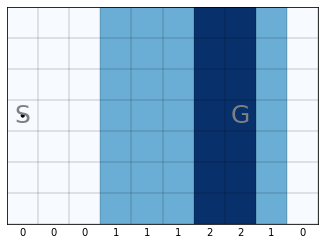

In [ ]:
windy_env = gym.make('WindyGridworld-v0')
windy_env.reset()
windy_env.render()

[0 3]
[0 3]
[1 3]
[0 3]


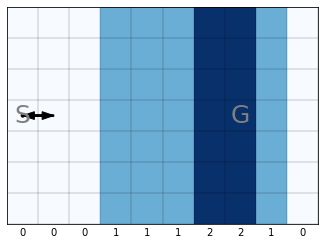

In [ ]:

for i_episode in range(1):
    observation = windy_env.reset()
    print(observation)
    for t in range(3):
        action = windy_env.action_space.sample()
        observation, reward, done, info = windy_env.step(action)
        print(observation)
        windy_env.render()
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break

#Define usefull functions
* eps_greedy
* q_learning_update
* sarsa_update
* validation_walk

## epsilon greedy

In [ ]:
def eps_greedy(q_vals, eps, state, env):
    """
    Inputs:
        q_vals: q value tables
        eps: epsilon
        state: current state
        env: environment
    Outputs:
        random action with probability of eps; argmax Q(s, .) with probability of (1-eps)
    """
    import random
    if random.random() <= eps:
        action = env.action_space.sample() # sample an action randomly # sample an action randomly
    else:
        action = np.argmax(q_vals[state,:])
    return action

## qlearning update

In [ ]:
def q_learning_update(gamma, alpha, q_vals, cur_state, action, next_state, reward):

    """
    Inputs:
        gamma: discount factor
        alpha: learning rate
        q_vals: q value table
        cur_state: current state
        action: action taken in current state
        next_state: next state results from taking `action` in `cur_state`
        reward: reward received from this transition
    
    Performs in-place update of q_vals table to implement one step of Q-learning
    """
## TO DO: Write a code to calculate delta and q_vals[cur_state,action]
    delta = reward + gamma * np.max(q_vals[next_state,:]) - q_vals[cur_state,action]
    q_vals[cur_state,action] += alpha * delta


## sarsa update

In [ ]:
def sarsa_update(gamma, alpha, q_vals, cur_state, current_action, next_state, next_action,reward):

    """
    Inputs:
        gamma: discount factor
        alpha: learning rate
        q_vals: q value table
        cur_state: current state
        action: action taken in current state
        next_state: next state results from taking `action` in `cur_state`
        next_action: action taken in next state
        reward: reward received from this transition
    
    Performs in-place update of q_vals table to implement one step of SARSA
    """
## TO DO: Write a code to calculate delta and q_vals[cur_state,action]
    delta = reward + gamma * q_vals[next_state,next_action] - q_vals[cur_state,current_action]
    q_vals[cur_state,current_action] += alpha * delta


## validation

In [ ]:
def validation_walk(env, q_vals):
  done = False
  total_reward = 0
  n_steps = 0
  cur_state = env.reset()
  while not done:
    cur_state = env.c_r_to_index(cur_state)
    action = np.argmax(q_vals[cur_state,:])
    next_state, reward, done, info = env.step(action)
    env.render()
    cur_state = next_state
    total_reward += reward
    n_steps += 1
  print('it took {0} steps with reward of {1}'.format(n_steps , total_reward))
  return n_steps, total_reward

## plot optimal policy

In [ ]:
def plot_optimal_policy(env,Q):
  fig = plt.figure()
  ax = fig.gca()

  # Background colored by wind strength
  wind = np.vstack([env.wind] * env.size[1])
  ax.imshow(wind, aspect='equal', origin='lower', cmap='Blues')

  # Annotations at start and goal positions
  ax.annotate("G", env.goal, size=25, color='gray', ha='center', va='center')
  ax.annotate("S", env.start, size=25, color='gray', ha='center', va='center')

  # Major tick marks showing wind strength
  ax.set_xticks(np.arange(len(env.wind)))
  ax.set_xticklabels(env.wind)
  ax.set_yticks([])
  ax.set_yticklabels([])

  # Thin grid lines at minor tick mark locations
  ax.set_xticks(np.arange(-0.5, env.size[0]), minor=True)
  ax.set_yticks(np.arange(-0.5, env.size[1]), minor=True)
  ax.grid(which='minor', color='black', linewidth=0.20)
  ax.tick_params(which='both', length=0)
  ax.set_frame_on(True)

  for i,q in enumerate(Q):
    c,r = env.index_to_c_r(i)
    action = np.argmax(q)
    if action == 1: #right
      dx = 0.7
      dy = 0
      x = c - 0.3
      y = r
    elif action == 3: #left
      dx = -0.7
      dy = 0
      x = c + 0.3
      y = r
    elif action == 2: #down
      dx = 0
      dy = -0.7
      x = c 
      y = r + 0.3
    elif action == 0: #up
      dx = 0
      dy = 0.7
      x = c 
      y = r - 0.3

    #kings moves
    elif action == 4:
      dx = 0.7
      dy = 0.7
      x = c - 0.3
      y = r - 0.3
    elif action == 5:
      dx = 0.7
      dy = -0.7
      x = c - 0.3
      y = r + 0.3
    elif action == 6:
      dx = -0.7
      dy = -0.7
      x = c + 0.3
      y = r + 0.3
    elif action == 7:
      dx = -0.7
      dy = 0.7
      x = c + 0.3
      y = r - 0.3
    patch = mpatches.FancyArrow( x,y,dx,dy, color='black',
                                              zorder=2, fill=True, width=0.05, head_width=0.25,
                                              length_includes_head=True)
    ax.add_patch(patch)
  plt.show()

## plot episode vs steps

In [ ]:
def plot_episode_vs_steps(steps_List, smooth_factor = 20):
  from scipy.interpolate import make_interp_spline
  plt.figure(figsize=(15,6))
  x = np.arange(len(steps_List))
  # plt.subplot(1,2,1)
  plt.xlabel("episode")
  plt.ylabel("steps")
  plt.title('episode vs steps')
  plt.plot(x, steps_List)
  # plt.subplot(1,2,2)
  X_Y_Spline = make_interp_spline(x, steps_List)
  xnew = np.linspace(x.min(), x.max(), smooth_factor)
  y_smoothed = X_Y_Spline(xnew)
  plt.plot(xnew,y_smoothed,color = 'red')




##plot_steps

In [ ]:
def plot_steps(model,alpha,epsilon,steps):
  plt.figure(1)
  plt.plot(steps)
  plt.title('{} (∈= {},α= {})'.format(model, alpha,epsilon), fontsize = 'large')
  plt.xlabel("Steps")
  plt.ylabel("Episodes")
  plt.show()

# Run algorithms

##NOTE: the reward is always -1 for each step so the plot of episode vs step is the mirrored plot of episodes vs reward on the x axis.

## saras algorithm

In [ ]:
def sarsa_algorithm(env, Q, episodes_num, epsilon, gamma, alpha):
  #SARSA
  rList = []
  steps_List = []
  s = []
  for itr in range(episodes_num):
      cur_state = env.reset()
      ret = 0
      steps = 0
      done = False
      cur_state_indx = env.c_r_to_index(cur_state)
      current_action = eps_greedy(Q, epsilon, cur_state_indx, env)
      while not done:
          next_state, reward, done, info = env.step(current_action)
          next_state_indx =  env.c_r_to_index(next_state)
          next_action = eps_greedy(Q, epsilon, next_state_indx, env)
          sarsa_update(gamma, alpha, Q, cur_state_indx, current_action, next_state_indx, next_action, reward)
          cur_state = next_state
          cur_state_indx = env.c_r_to_index(cur_state)
          current_action = next_action
          ret+=reward
          s.append(itr)
          steps += 1
      rList.append(ret)
      steps_List.append(steps)
  print ("Score over time: " +  str(sum(rList)/episodes_num))
  return rList, steps_List , s

## qlearning algorithm

In [ ]:
def q_learning_algorithm(env, Q, episodes_num, epsilon, gamma, alpha):
  #Q-learning
  rList = []
  steps_List = []
  s = []
  for itr in range(episodes_num):
      cur_state = env.reset()
      ret = 0
      steps = 0
      done = False
      while not done:
          cur_state_indx = env.c_r_to_index(cur_state)
          action = eps_greedy(Q, epsilon, cur_state_indx, env)
          next_state, reward, done, info = env.step(action)
          next_state_indx =  env.c_r_to_index(next_state)
          q_learning_update(gamma, alpha, Q, cur_state_indx, action, next_state_indx, reward)
          cur_state = next_state
          ret+=reward
          steps += 1
          s.append(itr)
      rList.append(ret)
      steps_List.append(steps)
  print ("Score over time: " +  str(sum(rList)/episodes_num))
  return rList, steps_List , s

# part1 : deterministic environment with only pawns_actions

In [ ]:
env = gym.make('WindyGridworld-v0',king=False, stop=False, stochastic=False)
episodes_num = 300
gamma = 0.95

I will choose the value of gamma to be 0.95 with 300 episodes for each trial

Then trying different values of alpha and epsilon

epsilon = [0.01 , 0.1]

alph = [0.5 , 0.8 , 0.9] 

## SARSA

### epsilon = 0.1 & alpha = 0.9

In [ ]:
epsilon = 0.1
alpha = 0.9

In [ ]:
Q = np.zeros([np.prod(env.observation_space.nvec),env.action_space.n])
rList, steps_List ,s = sarsa_algorithm(env, Q, episodes_num, epsilon, gamma, alpha)

Score over time: -40.406666666666666


it took 16 steps with reward of -16


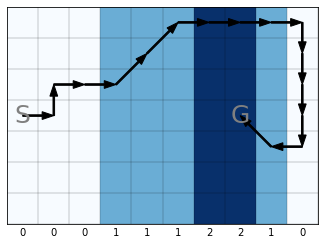

In [ ]:
optimal_steps , optimal_reward = validation_walk(env, Q)

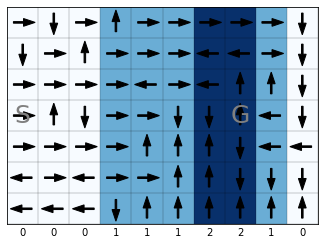

In [ ]:
plot_optimal_policy(env,Q)

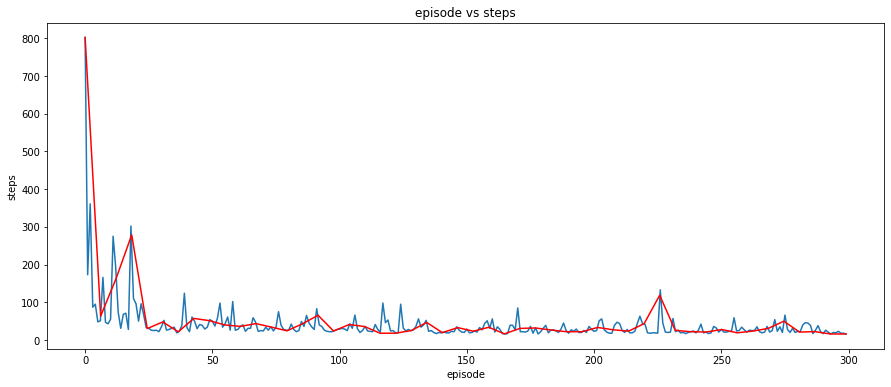

In [ ]:
plot_episode_vs_steps(steps_List, smooth_factor = 50)

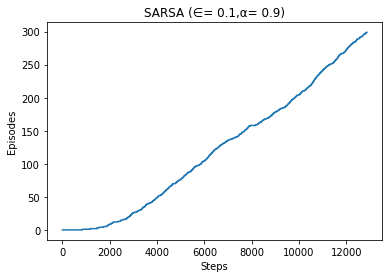

In [ ]:
plot_steps('SARSA',epsilon,alpha,s)

In [ ]:
print('min steps: ',min(steps_List))
print('eposide at which saras reached the optimal solution(min number of steps): ',steps_List.index(min(steps_List)))

min steps:  15
eposide at which saras reached the optimal solution(min number of steps):  275


### epsilon = 0.1 & alpha = 0.5

In [ ]:
epsilon = 0.1
alpha = 0.5

In [ ]:
Q = np.zeros([np.prod(env.observation_space.nvec),env.action_space.n])
rList, steps_List ,s = sarsa_algorithm(env, Q, episodes_num, epsilon, gamma, alpha)

Score over time: -38.25333333333333


it took 16 steps with reward of -16


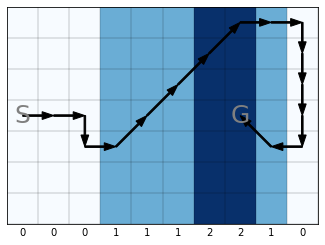

In [ ]:
optimal_steps , optimal_reward = validation_walk(env, Q)

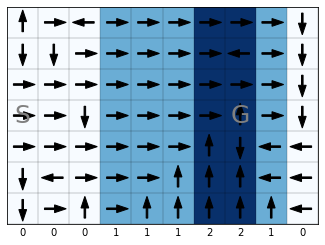

In [ ]:
plot_optimal_policy(env,Q)

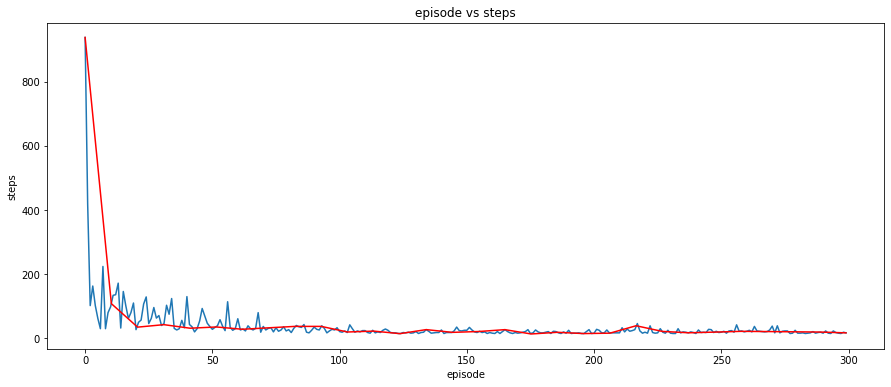

In [ ]:
plot_episode_vs_steps(steps_List, smooth_factor = 30)

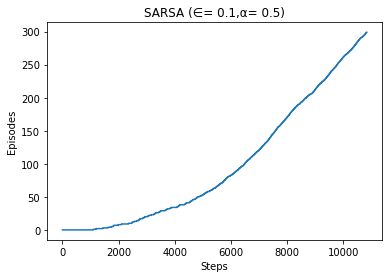

In [ ]:
plot_steps('SARSA',epsilon,alpha,s)

In [ ]:
print('min steps: ',min(steps_List))

print('eposide at which saras reached the optimal solution(min number of steps): ',steps_List.index(min(steps_List)))

min steps:  15
eposide at which saras reached the optimal solution(min number of steps):  135


### epsilon = 0.01 & alpha = 0.9

In [ ]:
epsilon = 0.01
alpha = 0.9

In [ ]:
Q = np.zeros([np.prod(env.observation_space.nvec),env.action_space.n])
rList, steps_List,s = sarsa_algorithm(env, Q, episodes_num, epsilon, gamma, alpha)

Score over time: -28.166666666666668


it took 15 steps with reward of -15


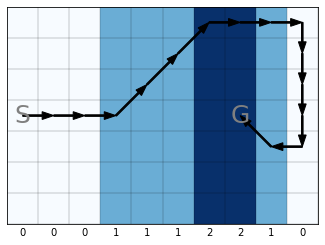

In [ ]:
optimal_steps , optimal_reward = validation_walk(env, Q)

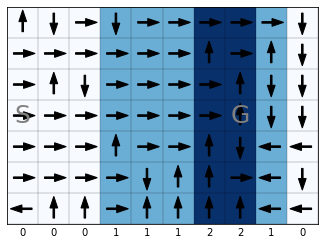

In [ ]:
plot_optimal_policy(env,Q)

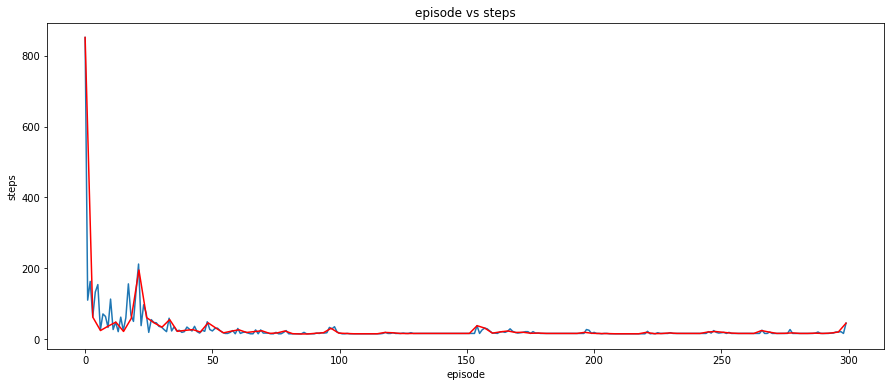

In [ ]:
plot_episode_vs_steps(steps_List, smooth_factor = 100)

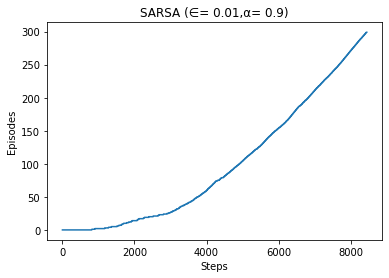

In [ ]:
plot_steps('SARSA',epsilon,alpha,s)

In [ ]:
print('min steps: ',min(steps_List))
print('eposide at which saras reached the optimal solution(min number of steps): ',steps_List.index(min(steps_List)))

min steps:  15
eposide at which saras reached the optimal solution(min number of steps):  61


### epsilon = 0.01 & alpha = 0.5

In [ ]:
epsilon = 0.01
alpha = 0.5

In [ ]:
Q = np.zeros([np.prod(env.observation_space.nvec),env.action_space.n])
rList, steps_List,s = sarsa_algorithm(env, Q, episodes_num, epsilon, gamma, alpha)

Score over time: -30.623333333333335


it took 15 steps with reward of -15


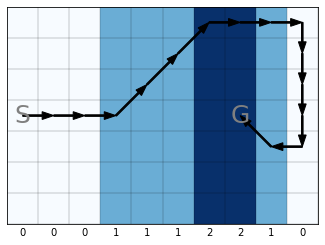

In [ ]:
optimal_steps , optimal_reward = validation_walk(env, Q)

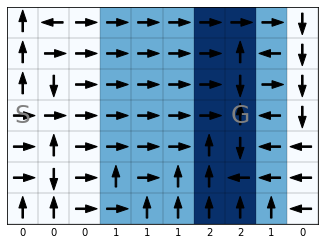

In [ ]:
plot_optimal_policy(env,Q)

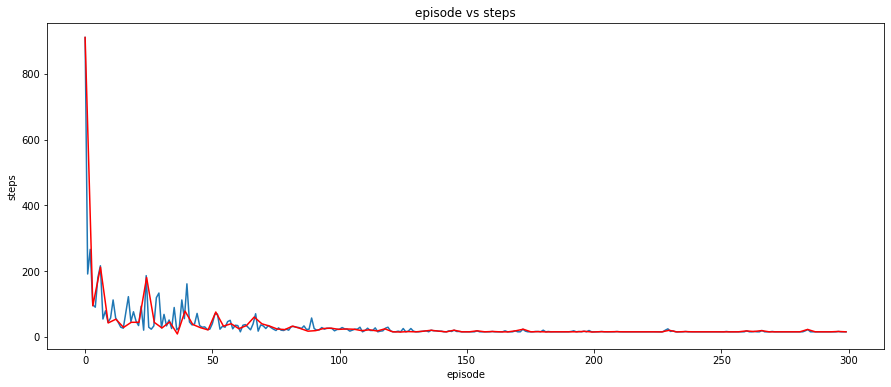

In [ ]:
plot_episode_vs_steps(steps_List, smooth_factor = 100)

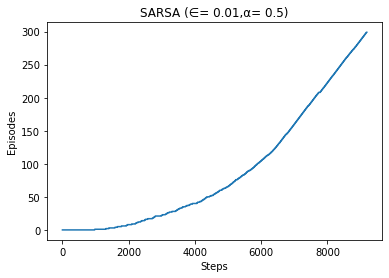

In [ ]:
plot_steps('SARSA',epsilon,alpha,s)

In [ ]:
print('min steps: ',min(steps_List))
print('eposide at which saras reached the optimal solution(min number of steps): ',steps_List.index(min(steps_List)))

min steps:  15
eposide at which saras reached the optimal solution(min number of steps):  72


### epsilon = 0.01 & alpha = 0.8

In [ ]:
epsilon = 0.01
alpha = 0.8

In [ ]:
Q = np.zeros([np.prod(env.observation_space.nvec),env.action_space.n])
rList, steps_List,s = sarsa_algorithm(env, Q, episodes_num, epsilon, gamma, alpha)

Score over time: -27.66


it took 15 steps with reward of -15


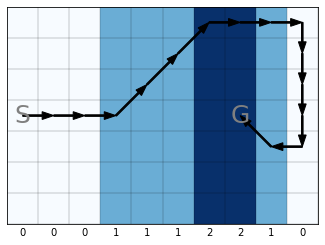

In [ ]:
optimal_steps , optimal_reward = validation_walk(env, Q)

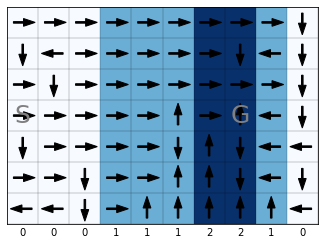

In [ ]:
plot_optimal_policy(env,Q)

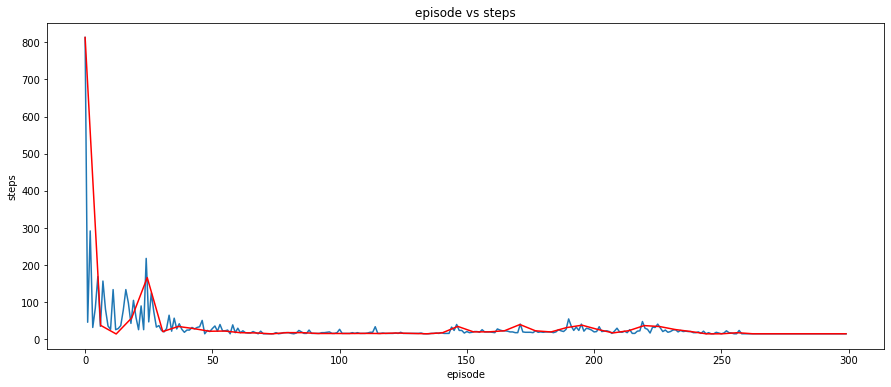

In [ ]:
plot_episode_vs_steps(steps_List, smooth_factor = 50)

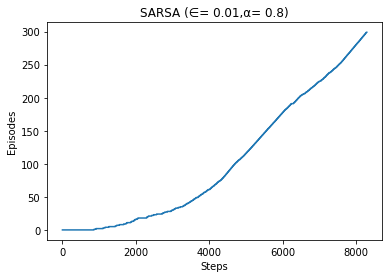

In [ ]:
plot_steps('SARSA',epsilon,alpha,s)

In [ ]:
print('min steps: ',min(steps_List))

print('eposide at which saras reached the optimal solution(min number of steps): ',steps_List.index(min(steps_List)))

min steps:  15
eposide at which saras reached the optimal solution(min number of steps):  71


## Q-learning

### epsilon = 0.1 & alpha = 0.9

In [ ]:
epsilon = 0.1
alpha = 0.9

In [ ]:
Q = np.zeros([np.prod(env.observation_space.nvec),env.action_space.n])
rList, steps_List, s = q_learning_algorithm(env, Q, episodes_num, epsilon, gamma, alpha)

Score over time: -26.523333333333333


it took 15 steps with reward of -15


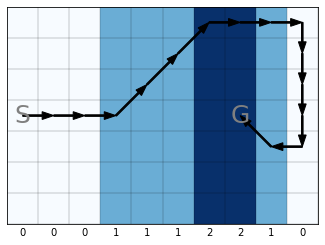

In [ ]:
optimal_steps , optimal_reward = validation_walk(env, Q)

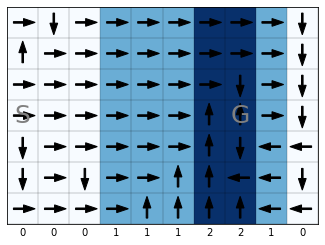

In [ ]:
plot_optimal_policy(env,Q)

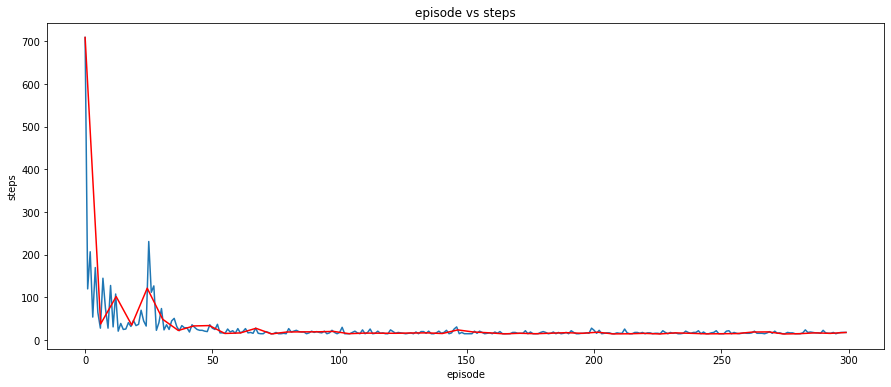

In [ ]:
plot_episode_vs_steps(steps_List, smooth_factor = 50)

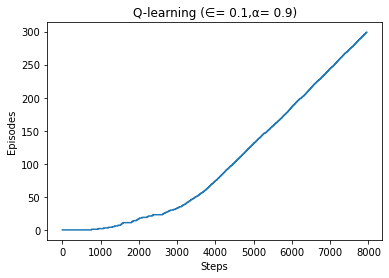

In [ ]:
plot_steps('Q-learning',epsilon,alpha,s)

In [ ]:
print('min steps: ',min(steps_List))
print('eposide at which q-learning reached the optimal solution(min number of steps): ',steps_List.index(min(steps_List)))

min steps:  15
eposide at which q-learning reached the optimal solution(min number of steps):  68


### epsilon = 0.1 & alpha = 0.5

In [ ]:
epsilon = 0.1
alpha = 0.5

In [ ]:
Q = np.zeros([np.prod(env.observation_space.nvec),env.action_space.n])
rList, steps_List, s = q_learning_algorithm(env, Q, episodes_num, epsilon, gamma, alpha)

Score over time: -32.276666666666664


it took 15 steps with reward of -15


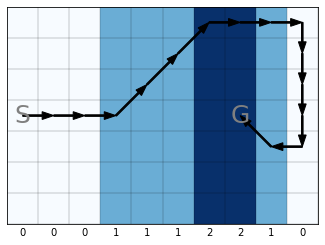

In [ ]:
optimal_steps , optimal_reward = validation_walk(env, Q)

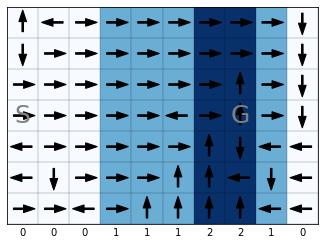

In [ ]:
plot_optimal_policy(env,Q)

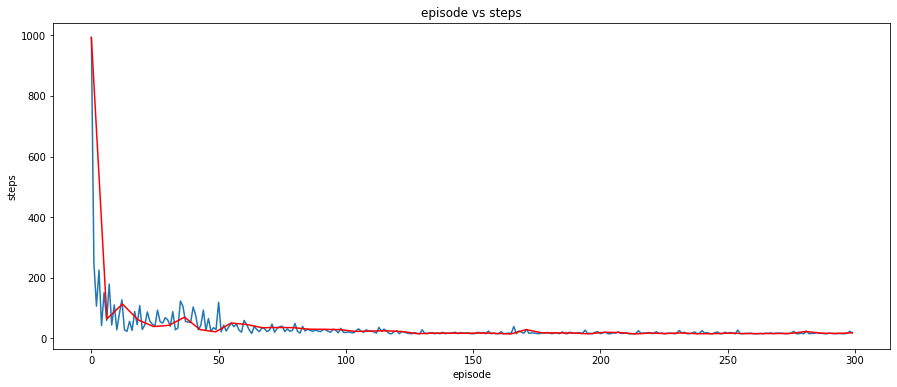

In [ ]:
plot_episode_vs_steps(steps_List, smooth_factor = 50)

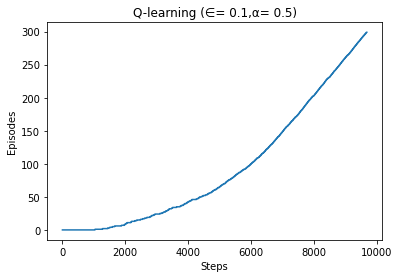

In [ ]:
plot_steps('Q-learning',epsilon,alpha,s)

In [ ]:
print('min steps: ',min(steps_List))
print('eposide at which q-learning reached the optimal solution(min number of steps): ',steps_List.index(min(steps_List)))

min steps:  15
eposide at which q-learning reached the optimal solution(min number of steps):  120


### epsilon = 0.01 & alpha = 0.9

In [ ]:
epsilon = 0.01
alpha = 0.9

In [ ]:
Q = np.zeros([np.prod(env.observation_space.nvec),env.action_space.n])
rList, steps_List, s = q_learning_algorithm(env, Q, episodes_num, epsilon, gamma, alpha)

Score over time: -23.673333333333332


it took 15 steps with reward of -15


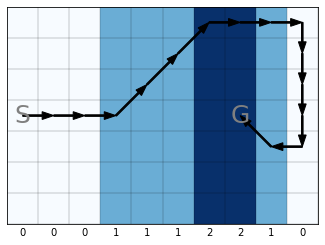

In [ ]:
optimal_steps , optimal_reward = validation_walk(env, Q)

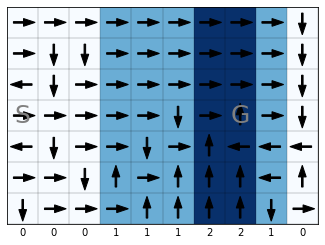

In [ ]:
plot_optimal_policy(env,Q)

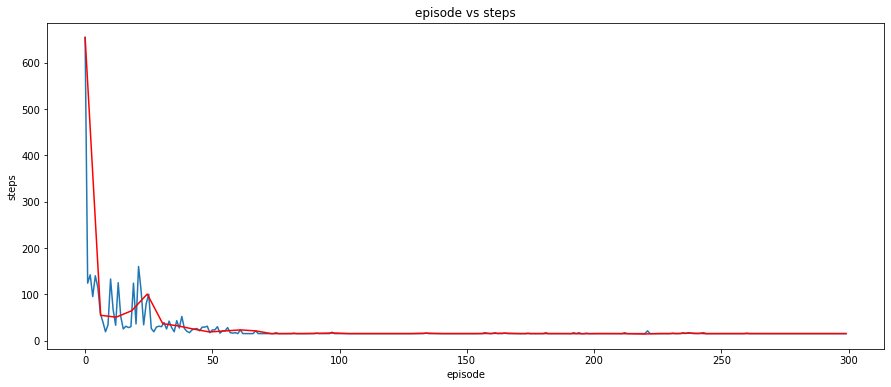

In [ ]:
plot_episode_vs_steps(steps_List, smooth_factor = 50)

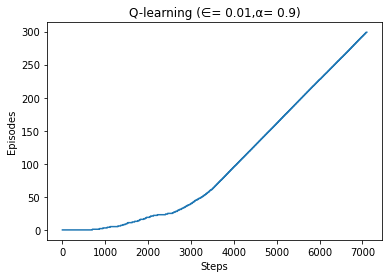

In [ ]:
plot_steps('Q-learning',epsilon,alpha,s)

In [ ]:
print('min steps: ',min(steps_List))

print('eposide at which q-learning reached the optimal solution(min number of steps): ',steps_List.index(min(steps_List)))

min steps:  15
eposide at which q-learning reached the optimal solution(min number of steps):  54


### epsilon = 0.01 & alpha = 0.5

In [ ]:
epsilon = 0.01
alpha = 0.5

In [ ]:
Q = np.zeros([np.prod(env.observation_space.nvec),env.action_space.n])
rList, steps_List, s = q_learning_algorithm(env, Q, episodes_num, epsilon, gamma, alpha)

Score over time: -29.75


it took 15 steps with reward of -15


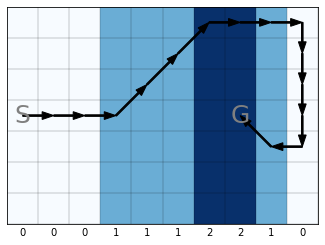

In [ ]:
optimal_steps , optimal_reward = validation_walk(env, Q)

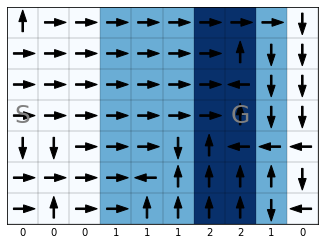

In [ ]:
plot_optimal_policy(env,Q)

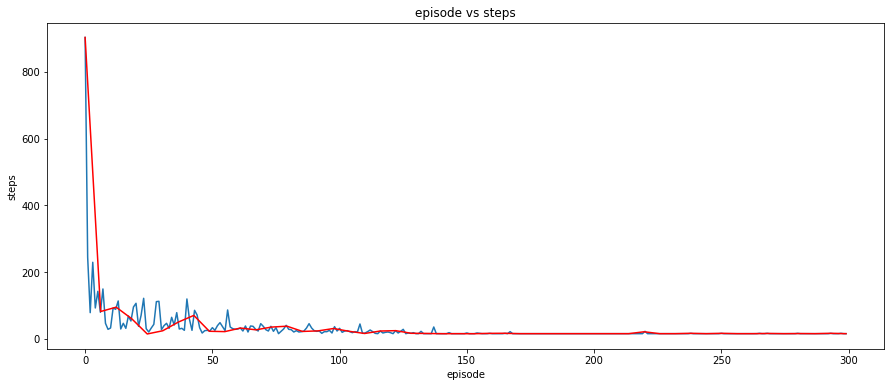

In [ ]:
plot_episode_vs_steps(steps_List, smooth_factor = 50)

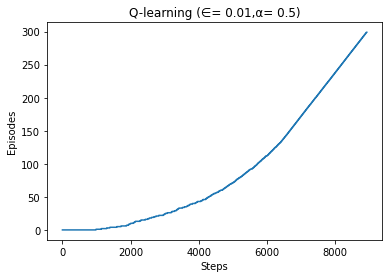

In [ ]:
plot_steps('Q-learning',epsilon,alpha,s)

In [ ]:
print('min steps: ',min(steps_List))

print('eposide at which q-learning reached the optimal solution(min number of steps): ',steps_List.index(min(steps_List)))

min steps:  15
eposide at which q-learning reached the optimal solution(min number of steps):  110


### epsilon = 0.01 & alpha = 0.8

In [ ]:
epsilon = 0.01
alpha = 0.8

In [ ]:
Q = np.zeros([np.prod(env.observation_space.nvec),env.action_space.n])
rList, steps_List, s = q_learning_algorithm(env, Q, episodes_num, epsilon, gamma, alpha)

Score over time: -24.586666666666666


it took 15 steps with reward of -15


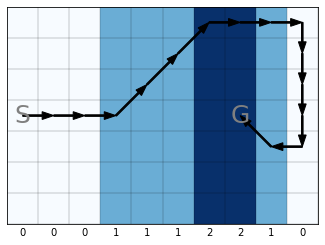

In [ ]:
optimal_steps , optimal_reward = validation_walk(env, Q)

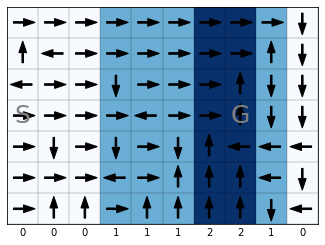

In [ ]:
plot_optimal_policy(env,Q)

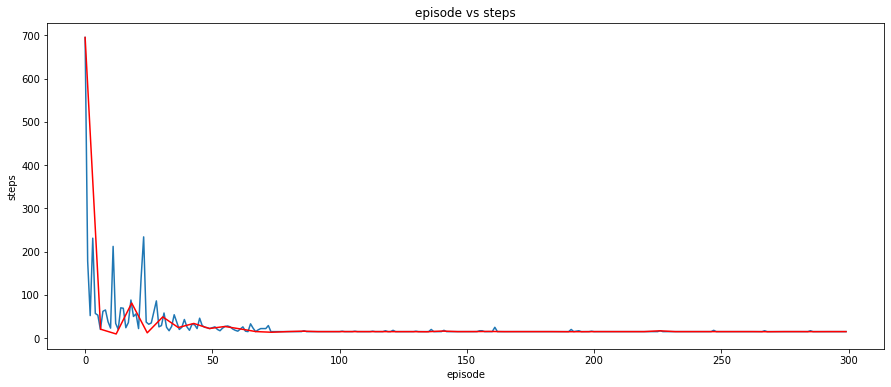

In [ ]:
plot_episode_vs_steps(steps_List, smooth_factor = 50)

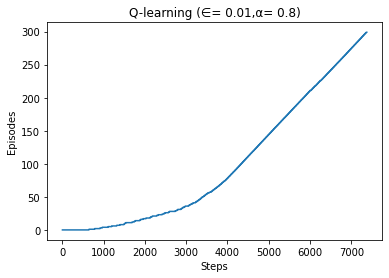

In [ ]:
plot_steps('Q-learning',epsilon,alpha,s)

In [ ]:
print('min steps: ',min(steps_List))
print('eposide at which q-learning reached the optimal solution(min number of steps): ',steps_List.index(min(steps_List)))

min steps:  15
eposide at which q-learning reached the optimal solution(min number of steps):  48


# part2 : stochastic environment with with King’s moves

In [ ]:
env = gym.make('WindyGridworld-v0',king=True, stop=False, stochastic=True)
episodes_num = 1000
gamma = 0.95

I will choose the value of gamma to be 0.95 with episodes for each trial

Then trying different values of alpha and epsilon

epsilon = [0.01 , 0.1]

alph = [0.5 , 0.8 , 0.9] 

## SARSA

### epsilon = 0.1 & alpha = 0.9

In [ ]:
epsilon = 0.1
alpha = 0.9

In [ ]:
Q = np.zeros([np.prod(env.observation_space.nvec),env.action_space.n])
rList, steps_List,s = sarsa_algorithm(env, Q, episodes_num, epsilon, gamma, alpha)

Score over time: -91.482


it took 5000 steps with reward of -5000


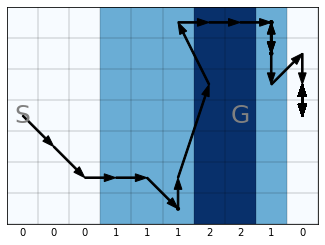

In [ ]:
optimal_steps , optimal_reward = validation_walk(env, Q)

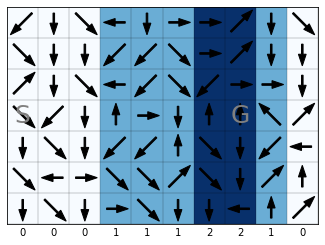

In [ ]:
plot_optimal_policy(env,Q)

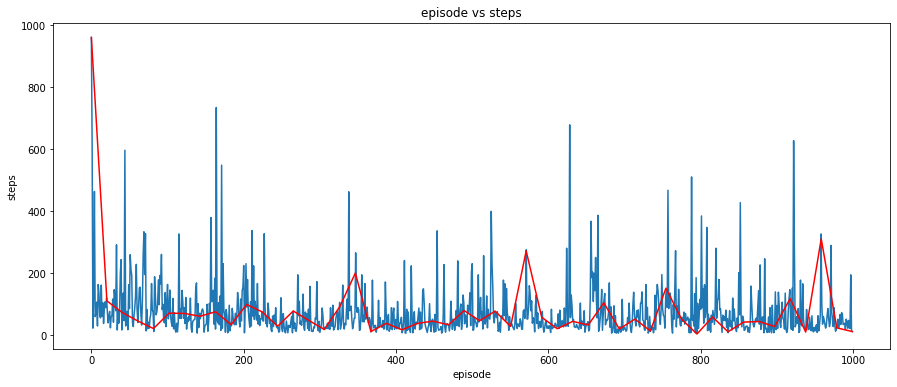

In [ ]:
plot_episode_vs_steps(steps_List, smooth_factor = 50)

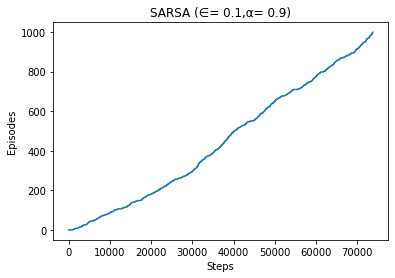

In [ ]:
plot_steps('SARSA',epsilon,alpha,s)

In [ ]:
print('min steps: ',min(steps_List))
print('eposide at which saras reached the optimal solution(min number of steps): ',steps_List.index(min(steps_List)))

min steps:  7
eposide at which saras reached the optimal solution(min number of steps):  190


### epsilon = 0.1 & alpha = 0.5

In [ ]:
epsilon = 0.1
alpha = 0.5

In [ ]:
Q = np.zeros([np.prod(env.observation_space.nvec),env.action_space.n])
rList, steps_List, s = sarsa_algorithm(env, Q, episodes_num, epsilon, gamma, alpha)

Score over time: -42.482


it took 24 steps with reward of -24


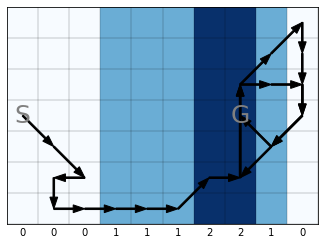

In [ ]:
optimal_steps , optimal_reward = validation_walk(env, Q)

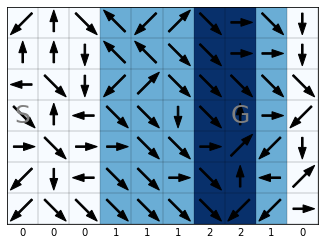

In [ ]:
plot_optimal_policy(env,Q)

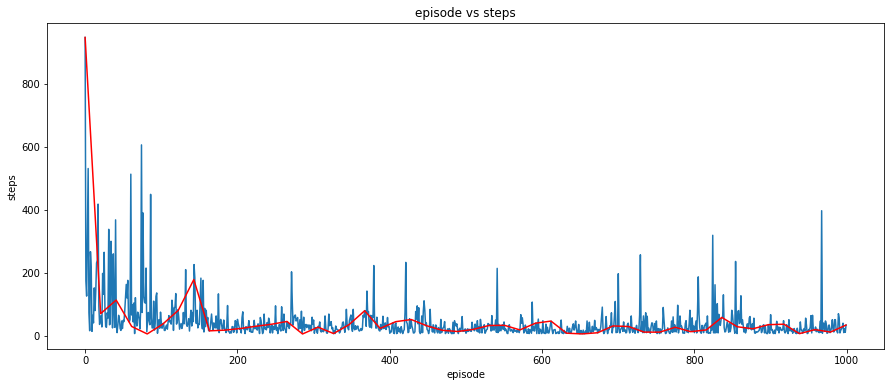

In [ ]:
plot_episode_vs_steps(steps_List, smooth_factor = 50)

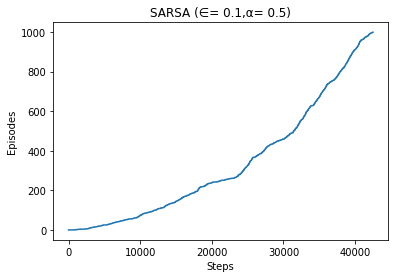

In [ ]:
plot_steps('SARSA',epsilon,alpha,s)

In [ ]:
print('min steps: ',min(steps_List))
print('eposide at which saras reached the optimal solution(min number of steps): ',steps_List.index(min(steps_List)))

min steps:  7
eposide at which saras reached the optimal solution(min number of steps):  191


### epsilon = 0.01 & alpha = 0.9

In [ ]:
epsilon = 0.01
alpha = 0.9

In [ ]:
Q = np.zeros([np.prod(env.observation_space.nvec),env.action_space.n])
rList, steps_List,s = sarsa_algorithm(env, Q, episodes_num, epsilon, gamma, alpha)

Score over time: -44.69


it took 8 steps with reward of -8


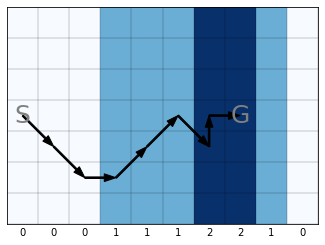

In [ ]:
optimal_steps , optimal_reward = validation_walk(env, Q)

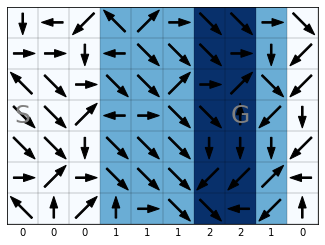

In [ ]:
plot_optimal_policy(env,Q)

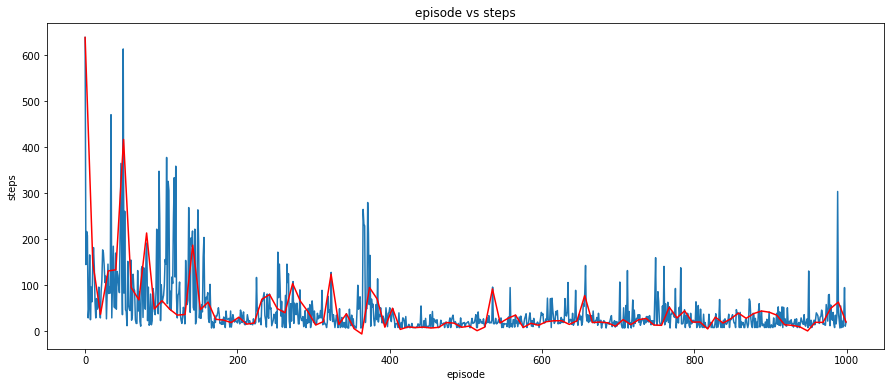

In [ ]:
plot_episode_vs_steps(steps_List, smooth_factor = 100)

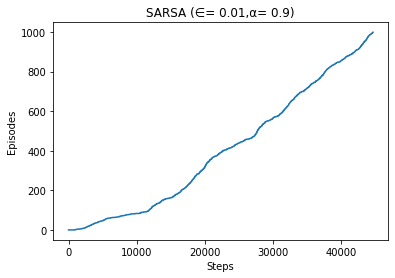

In [ ]:
plot_steps('SARSA',epsilon,alpha,s)

In [ ]:
print('min steps: ',min(steps_List))
print('eposide at which saras reached the optimal solution(min number of steps): ',steps_List.index(min(steps_List)))

min steps:  7
eposide at which saras reached the optimal solution(min number of steps):  166


### epsilon = 0.01 & alpha = 0.5

In [ ]:
epsilon = 0.01
alpha = 0.5

In [ ]:
Q = np.zeros([np.prod(env.observation_space.nvec),env.action_space.n])
rList, steps_List,s = sarsa_algorithm(env, Q, episodes_num, epsilon, gamma, alpha)

Score over time: -33.4


it took 7 steps with reward of -7


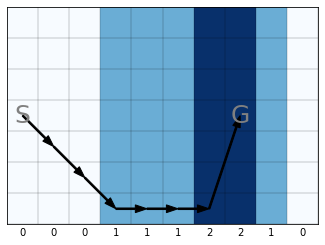

In [ ]:
optimal_steps , optimal_reward = validation_walk(env, Q)

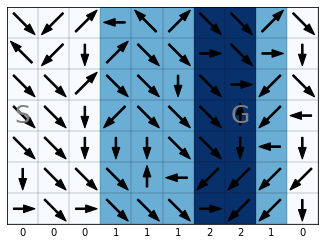

In [ ]:
plot_optimal_policy(env,Q)

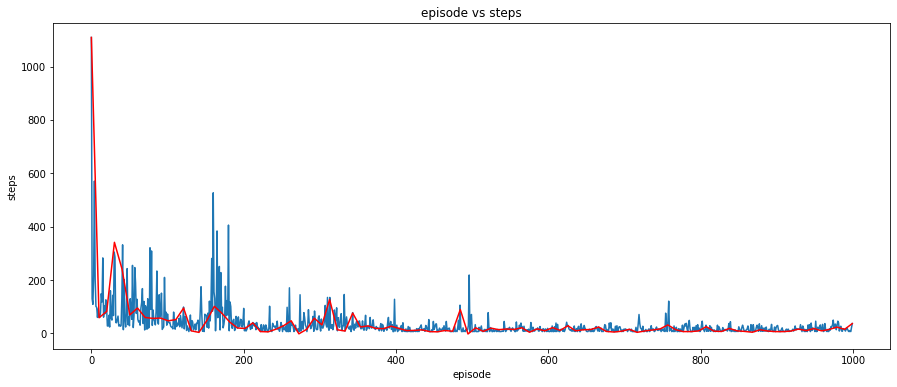

In [ ]:
plot_episode_vs_steps(steps_List, smooth_factor = 100)

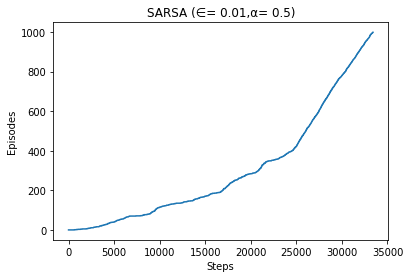

In [ ]:
plot_steps('SARSA',epsilon,alpha,s)

In [ ]:
print('min steps: ',min(steps_List))
print('eposide at which saras reached the optimal solution(min number of steps): ',steps_List.index(min(steps_List)))

min steps:  7
eposide at which saras reached the optimal solution(min number of steps):  205


### epsilon = 0.01 & alpha = 0.8

In [ ]:
epsilon = 0.01
alpha = 0.8

In [ ]:
Q = np.zeros([np.prod(env.observation_space.nvec),env.action_space.n])
rList, steps_List, s = sarsa_algorithm(env, Q, episodes_num, epsilon, gamma, alpha)

Score over time: -38.47


it took 10 steps with reward of -10


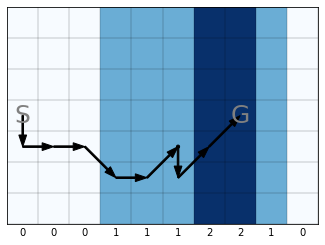

In [ ]:
optimal_steps , optimal_reward = validation_walk(env, Q)

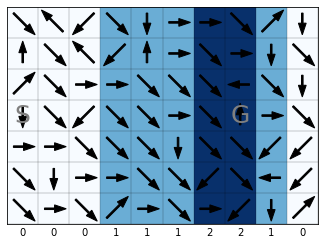

In [ ]:
plot_optimal_policy(env,Q)

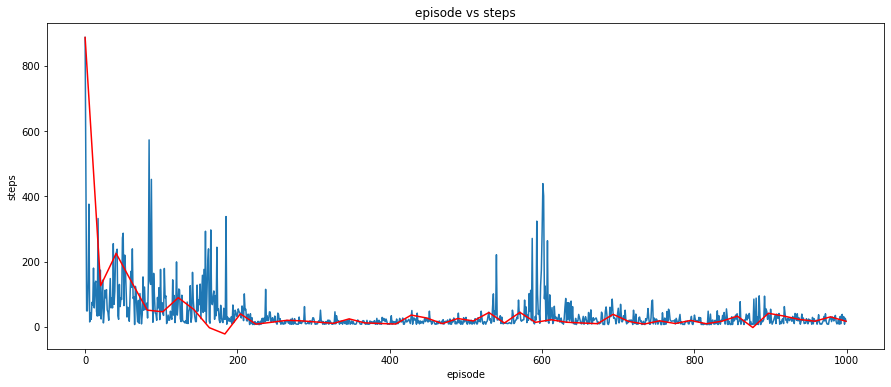

In [ ]:
plot_episode_vs_steps(steps_List, smooth_factor = 50)

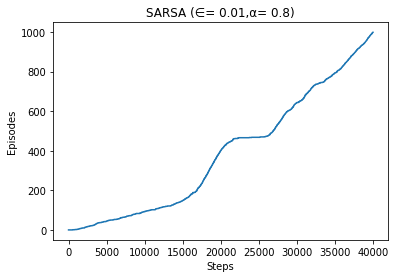

In [ ]:
plot_steps('SARSA',epsilon,alpha,s)

In [ ]:
print('min steps: ',min(steps_List))
print('eposide at which saras reached the optimal solution(min number of steps): ',steps_List.index(min(steps_List)))

min steps:  7
eposide at which saras reached the optimal solution(min number of steps):  65


## Q-learning

### epsilon = 0.1 & alpha = 0.9

In [ ]:
epsilon = 0.1
alpha = 0.9

In [ ]:
Q = np.zeros([np.prod(env.observation_space.nvec),env.action_space.n])
rList, steps_List, s = q_learning_algorithm(env, Q, episodes_num, epsilon, gamma, alpha)

Score over time: -74.277


it took 8 steps with reward of -8


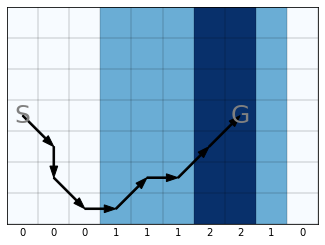

In [ ]:
optimal_steps , optimal_reward = validation_walk(env, Q)

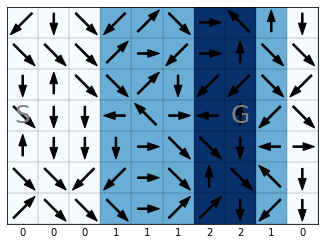

In [ ]:
plot_optimal_policy(env,Q)

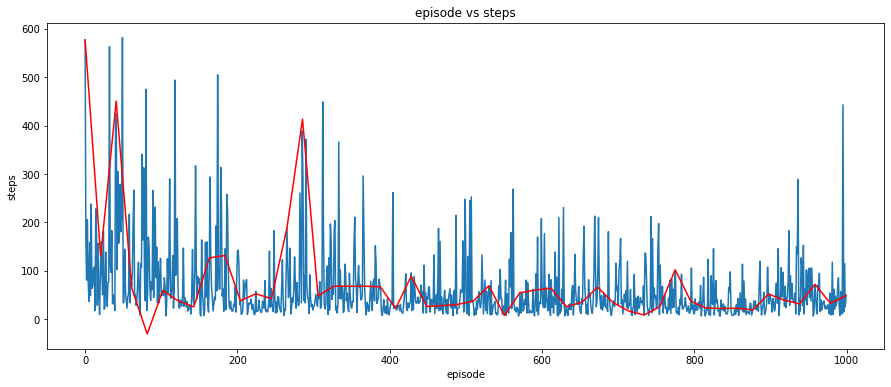

In [ ]:
plot_episode_vs_steps(steps_List, smooth_factor = 50)

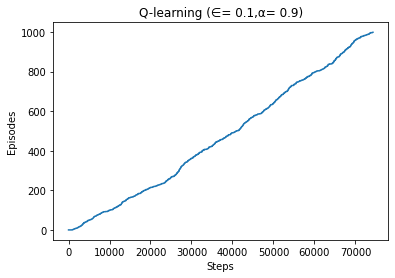

In [ ]:
plot_steps('Q-learning',epsilon,alpha,s)

In [ ]:
print('min steps: ',min(steps_List))
print('eposide at which q-learning reached the optimal solution(min number of steps): ',steps_List.index(min(steps_List)))

min steps:  7
eposide at which q-learning reached the optimal solution(min number of steps):  149


### epsilon = 0.1 & alpha = 0.5

In [ ]:
epsilon = 0.1
alpha = 0.5

In [ ]:
Q = np.zeros([np.prod(env.observation_space.nvec),env.action_space.n])
rList, steps_List,s = q_learning_algorithm(env, Q, episodes_num, epsilon, gamma, alpha)

Score over time: -39.276


it took 7 steps with reward of -7


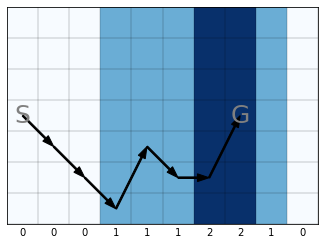

In [ ]:
optimal_steps , optimal_reward = validation_walk(env, Q)

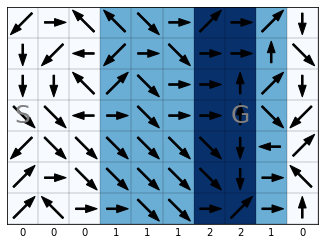

In [ ]:
plot_optimal_policy(env,Q)

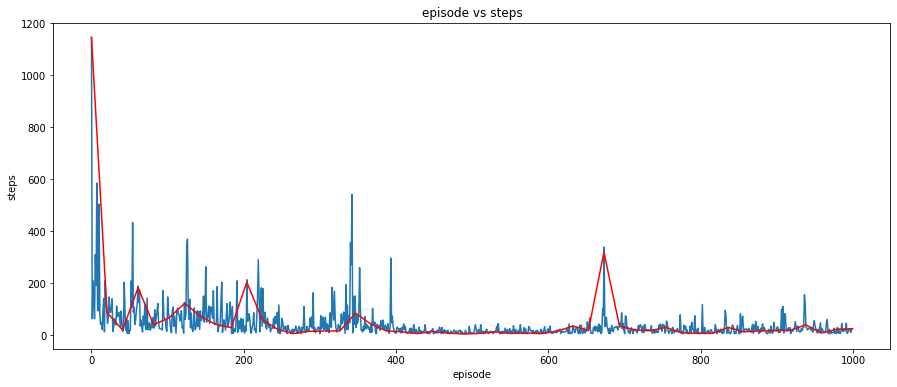

In [ ]:
plot_episode_vs_steps(steps_List, smooth_factor = 50)

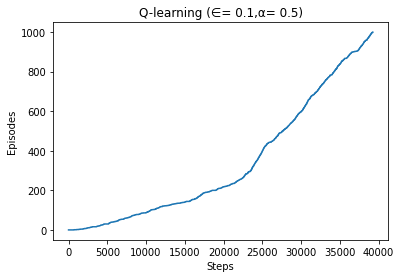

In [ ]:
plot_steps('Q-learning',epsilon,alpha,s)

In [ ]:
print('min steps: ',min(steps_List))
print('eposide at which q-learning reached the optimal solution(min number of steps): ',steps_List.index(min(steps_List)))

min steps:  7
eposide at which q-learning reached the optimal solution(min number of steps):  49


### epsilon = 0.01 & alpha = 0.9

In [ ]:
epsilon = 0.01
alpha = 0.9

In [ ]:
Q = np.zeros([np.prod(env.observation_space.nvec),env.action_space.n])
rList, steps_List,s = q_learning_algorithm(env, Q, episodes_num, epsilon, gamma, alpha)

Score over time: -41.203


it took 21 steps with reward of -21


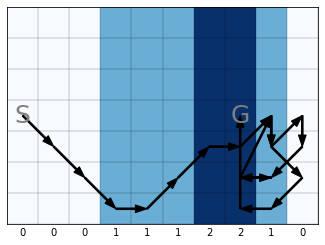

In [ ]:
optimal_steps , optimal_reward = validation_walk(env, Q)

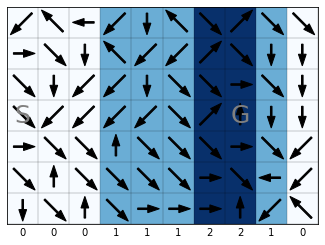

In [ ]:
plot_optimal_policy(env,Q)

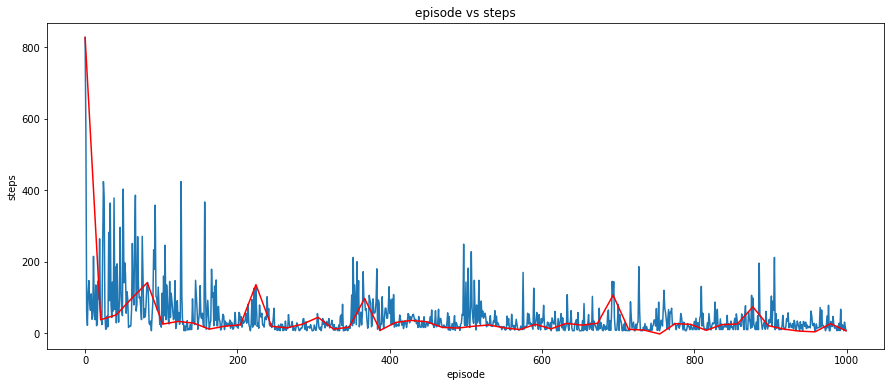

In [ ]:
plot_episode_vs_steps(steps_List, smooth_factor = 50)

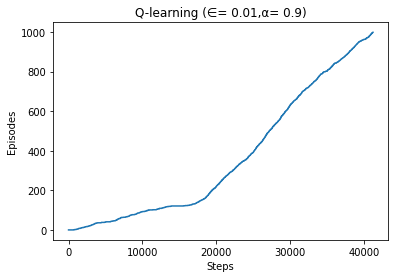

In [ ]:
plot_steps('Q-learning',epsilon,alpha,s)

In [ ]:
print('min steps: ',min(steps_List))
print('eposide at which q-learning reached the optimal solution(min number of steps): ',steps_List.index(min(steps_List)))

min steps:  7
eposide at which q-learning reached the optimal solution(min number of steps):  87


### epsilon = 0.01 & alpha = 0.5

In [ ]:
epsilon = 0.01
alpha = 0.5

In [ ]:
Q = np.zeros([np.prod(env.observation_space.nvec),env.action_space.n])
rList, steps_List,s = q_learning_algorithm(env, Q, episodes_num, epsilon, gamma, alpha)

Score over time: -32.065


it took 39 steps with reward of -39


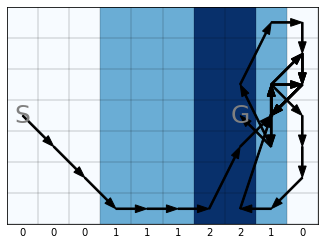

In [ ]:
optimal_steps , optimal_reward = validation_walk(env, Q)

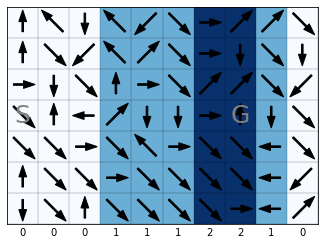

In [ ]:
plot_optimal_policy(env,Q)

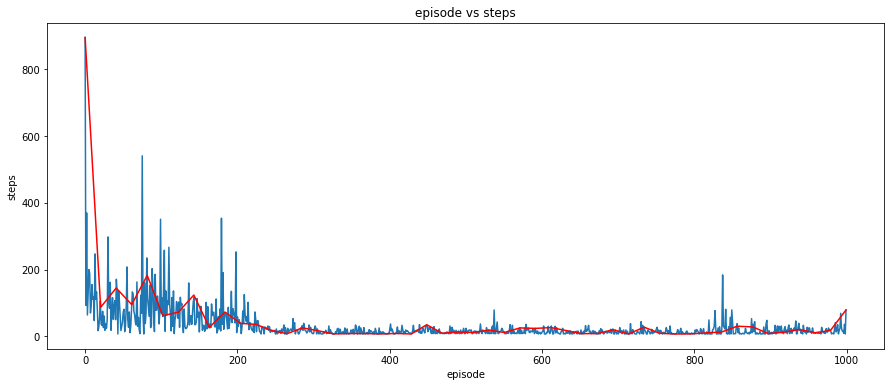

In [ ]:
plot_episode_vs_steps(steps_List, smooth_factor = 50)

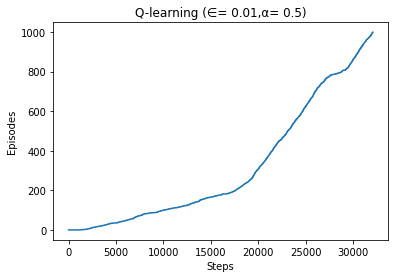

In [ ]:
plot_steps('Q-learning',epsilon,alpha,s)

In [ ]:
print('min steps: ',min(steps_List))
print('eposide at which q-learning reached the optimal solution(min number of steps): ',steps_List.index(min(steps_List)))

min steps:  7
eposide at which q-learning reached the optimal solution(min number of steps):  43


### epsilon = 0.01 & alpha = 0.8

In [ ]:
epsilon = 0.01
alpha = 0.8

In [ ]:
Q = np.zeros([np.prod(env.observation_space.nvec),env.action_space.n])
rList, steps_List, s = q_learning_algorithm(env, Q, episodes_num, epsilon, gamma, alpha)

Score over time: -36.007


it took 7 steps with reward of -7


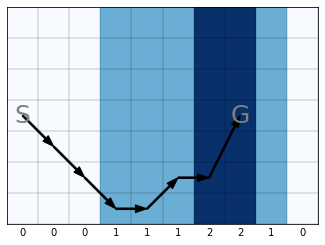

In [ ]:
optimal_steps , optimal_reward = validation_walk(env, Q)

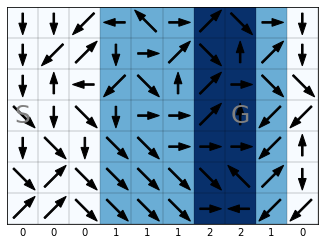

In [ ]:
plot_optimal_policy(env,Q)

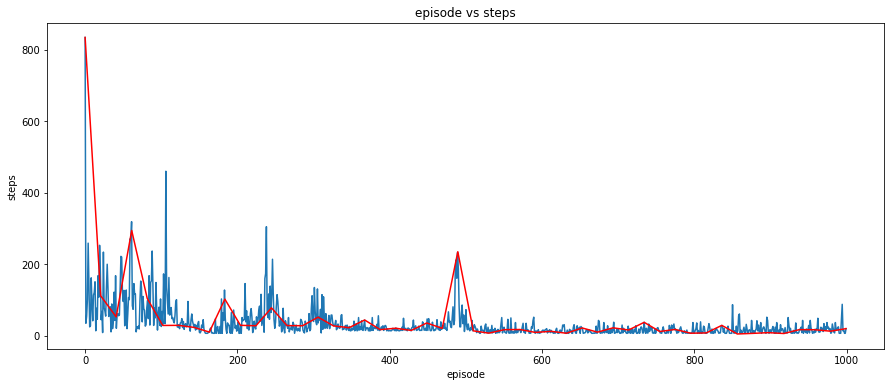

In [ ]:
plot_episode_vs_steps(steps_List, smooth_factor = 50)

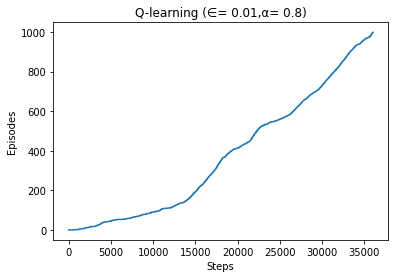

In [ ]:
plot_steps('Q-learning',epsilon,alpha,s)

In [ ]:
print('min steps: ',min(steps_List))
print('eposide at which q-learning reached the optimal solution(min number of steps): ',steps_List.index(min(steps_List)))

min steps:  7
eposide at which q-learning reached the optimal solution(min number of steps):  158


#ref

RL lab 2 : tutorial_Tabular_Q_Learning_V2.ipynb

environment code :  https://github.com/vojtamolda/reinforcement-learning-an-introduction/blob/main/chapter06/windy.py
